In [1]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 18.2 MB/s eta 0:00:00


In [2]:
# Standard & OS
import os
from collections import Counter

# Data Science & Visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

# PyTorch Core
import torch
import torch.nn.functional as F

# PyTorch Geometric
import torch_geometric
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GATConv, GCNConv, BatchNorm

# Environment specific
from google.colab import drive

In [12]:
# =================
# 1. SETUP & PATHS
# =================
from google.colab import drive
import os
import torch
import torch_geometric
from datetime import datetime

drive.mount('/content/drive')

# Core Paths
BASE_PATH = "/content/drive/MyDrive/Datasets/NUCLS_dataset"
CSV_DIR = os.path.join(BASE_PATH, "csv")
SPLITS_DIR = os.path.join(BASE_PATH, "train_test_splits")

# making classes
CLASSES = ['Tumor', 'Stroma', 'Immune', 'Other']

# Fix for PyTorch 2.6+ serialization
# Added typical GNN structures to safe_globals to prevent loading errors
torch.serialization.add_safe_globals([
    torch_geometric.data.Data,
    torch_geometric.data.data.Data,
    torch_geometric.data.storage.GlobalStorage,
    torch_geometric.data.storage.NodeStorage,
    torch_geometric.data.storage.EdgeStorage,
])

# Device Configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Research Metadata
print(f" Environment Initialized")
print(f"Device: {device}")
print(f"Analysis Mode: Pathology Data Based GNN Comparsion")
print(f"Target Classes: {CLASSES}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Environment Initialized
Device: cpu
Analysis Mode: Pathology Data Based GNN Comparsion
Target Classes: ['Tumor', 'Stroma', 'Immune', 'Other']


In [4]:
# ==========================================
# 2. HELPER FUNCTIONS
# ==========================================
def get_class_id(row):
    """
    Refined Mapping for Higher Accuracy:
    Class 0: Tumor
    Class 1: Fibroblasts/Stroma
    Class 2: Immune (Lymphocytes + Plasma + Macrophages)
    Class 3: Other (Real Noise/Artifacts)
    """
    text = (str(row.get('super_classification', '')) + " " +
            str(row.get('main_classification', ''))).lower()

    # Class 0: Tumor
    if any(x in text for x in ['tumor', 'mitotic', 'malignant']):
        return 0

    # Class 1: Stroma (Fibroblasts, Vascular, Endothelial)
    if any(x in text for x in ['fibro', 'stromal', 'vasc', 'endo']):
        return 1

    # Class 2: Immune Super-Class
    if any(x in text for x in ['lymph', 'til', 'plasma', 'immune', 'macro']):
        return 2

    # Class 3: True Other (Small, rare debris)
    return 3

def calculate_global_weights(dataset):
    print("Calculating biologically-balanced class weights...")
    all_y = []
    for i in range(len(dataset)):
        all_y.extend(dataset[i].y.tolist())

    counts = Counter(all_y)
    total = sum(counts.values())

    # Inverse Frequency formula
    weights = torch.tensor([total / (4 * counts[i]) for i in range(4)])

    # Down-weight the 'Other' class (Index 3) by 50%
    # This forces the GAT to focus its attention on Tumor/Stroma/Immune
    weights[3] = weights[3] * 0.5

    return weights

In [8]:
# ========================
# DATASET CLASS For GNN
# ========================
class NuCLSDataset(Dataset):
    def __init__(self, root, split_file, csv_dir, mode='train'):
        self.csv_dir = csv_dir
        self.file_list = pd.read_csv(split_file)
        self.slides = self.file_list['slide_name'].unique().tolist()
        #Unique folder per mode
        self.local_processed_dir = f"/content/processed_{mode}"

        if not os.path.exists(self.local_processed_dir):
            os.makedirs(self.local_processed_dir)

        super(NuCLSDataset, self).__init__(root)

    @property
    def processed_file_names(self):
        # If folder is empty, return empty list to trigger processing
        files = [f for f in os.listdir(self.local_processed_dir) if f.endswith('.pt')]
        return files

    def process(self):
        all_csvs = [f for f in os.listdir(self.csv_dir) if f.endswith('.csv')]
        count = 0
        print(f"Processing {len(self.slides)} slides for this split...")

        for slide in self.slides:
            matching_fovs = [f for f in all_csvs if f.startswith(slide)]
            for fov in matching_fovs:
                df = pd.read_csv(os.path.join(self.csv_dir, fov))

                # Skip small graphs
                num_nuclei = len(df)
                if num_nuclei < 2: continue

                # 1. Features
                pos_np = np.stack([(df['xmin']+df['xmax'])/2, (df['ymin']+df['ymax'])/2], axis=1)
                pos = torch.from_numpy(pos_np).to(torch.float)

                area_np = ((df['xmax']-df['xmin'])*(df['ymax']-df['ymin'])).values / 2000.0
                area = torch.from_numpy(area_np).to(torch.float).view(-1, 1)
                x = torch.cat([area, pos/1000.0], dim=1) # 3 features: Area, X, Y

                # 2. Labels
                y = torch.tensor(df.apply(get_class_id, axis=1).values, dtype=torch.long)

                # 3. Graph Connections
                k = min(6, num_nuclei)
                nbrs = NearestNeighbors(n_neighbors=k).fit(pos_np)
                adj = nbrs.kneighbors_graph(pos_np).tocoo()

                edge_index = torch.from_numpy(np.array([adj.row, adj.col])).to(torch.long)

                # 4. Save
                data = Data(x=x, edge_index=edge_index, y=y, pos=pos)
                torch.save(data, os.path.join(self.local_processed_dir, f'data_{count}.pt'))
                count += 1

        print(f"Created {count} graphs in {self.local_processed_dir}")

    def len(self):
        return len([f for f in os.listdir(self.local_processed_dir) if f.endswith('.pt')])

    def get(self, idx):
        return torch.load(os.path.join(self.local_processed_dir, f'data_{idx}.pt'), weights_only=False)

# GNN

In [9]:
class PathologyGNN(torch.nn.Module):
    def __init__(self):
        super(PathologyGNN, self).__init__()
        self.conv1 = GCNConv(3, 64)
        self.conv2 = GCNConv(64, 32)
        self.conv3 = GCNConv(32, 4)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        return F.log_softmax(self.conv3(x, edge_index), dim=1)

In [11]:
# ==========================================
# GNN. TRAINING LOOP
# ==========================================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_split = os.path.join(SPLITS_DIR, "fold_1_train.csv")
test_split = os.path.join(SPLITS_DIR, "fold_1_test.csv")
dataset = NuCLSDataset(root='/content/', split_file=train_split, csv_dir=CSV_DIR)

test_dataset = NuCLSDataset(root='/content/', split_file=test_split, csv_dir=CSV_DIR, mode='test')
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Get the weights
class_weights = calculate_global_weights(dataset).to(device)
print(f"Computed Weights (Tumor, Fibro, Lymph, Other): {class_weights.cpu().numpy()}")

train_loader = DataLoader(dataset, batch_size=4, shuffle=True)
model = PathologyGNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

print("\n--- Starting Weighted Training ---")
model.train()
for epoch in range(101):
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)

        # Applying Global Weights
        loss = F.nll_loss(out, batch.y, weight=class_weights)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    if epoch % 5 == 0:
        print(f"Epoch {epoch:02d} | Loss: {total_loss/len(train_loader):.4f}")

torch.save(model.state_dict(), 'pathology_gnn_weighted.pth')
print("Training complete. Model saved.")

Processing...


Processing 102 slides for this split...
Created 1481 graphs in /content/processed_train


Done!
Processing...


Processing 22 slides for this split...
Created 263 graphs in /content/processed_test
Calculating biologically-balanced class weights...


Done!


Computed Weights (Tumor, Fibro, Lymph, Other): [0.70972335 1.4230748  0.7674654  0.8542537 ]

--- Starting Weighted Training ---
Epoch 00 | Loss: 1.1379
Epoch 05 | Loss: 1.1050
Epoch 10 | Loss: 1.1007
Epoch 15 | Loss: 1.0968
Epoch 20 | Loss: 1.0944
Epoch 25 | Loss: 1.0897
Epoch 30 | Loss: 1.0922
Epoch 35 | Loss: 1.0888
Epoch 40 | Loss: 1.0894
Epoch 45 | Loss: 1.0925
Epoch 50 | Loss: 1.0852
Epoch 55 | Loss: 1.0903
Epoch 60 | Loss: 1.0864
Epoch 65 | Loss: 1.0821
Epoch 70 | Loss: 1.0870
Epoch 75 | Loss: 1.0845
Epoch 80 | Loss: 1.0856
Epoch 85 | Loss: 1.0903
Epoch 90 | Loss: 1.0835
Epoch 95 | Loss: 1.0812
Epoch 100 | Loss: 1.0821
Training complete. Model saved.


In [13]:
# 1. Ensure model is in evaluation mode
model.eval()
all_y_true = []
all_y_pred = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch)
        all_y_true.extend(batch.y.cpu().numpy())
        all_y_pred.extend(out.argmax(dim=1).cpu().numpy())

# 2. Calculate Overall Accuracy
overall_acc = accuracy_score(all_y_true, all_y_pred)

print(f"=======================================")
print(f"OVERALL TEST ACCURACY: {overall_acc*100:.2f}%")
print(f"=======================================\n")

# 3. Calculate Per-Class Accuracy (The "Deep Dive")
cm = confusion_matrix(all_y_true, all_y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

for i, class_name in enumerate(CLASSES):
    print(f"{class_name} Accuracy: {per_class_acc[i]*100:.2f}%")

OVERALL TEST ACCURACY: 51.61%

Tumor Accuracy: 86.37%
Stroma Accuracy: 30.88%
Immune Accuracy: 38.25%
Other Accuracy: 0.00%


# GAT Model

In [14]:
# ==========================================
# GAT. MODEL DEFINITION
# ==========================================
class PathologyGAT(torch.nn.Module):
    def __init__(self, in_channels=3, hidden_channels=64, out_channels=4):
        super(PathologyGAT, self).__init__()
        self.conv1 = GATConv(in_channels, hidden_channels, heads=4, concat=True)
        self.conv2 = GATConv(hidden_channels * 4, hidden_channels, heads=1)
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Local Normalization
        x_mean = x.mean(dim=0, keepdim=True)
        x_std = x.std(dim=0, keepdim=True) + 1e-6
        x = (x - x_mean) / x_std

        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.3, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(self.lin(x), dim=1)

In [15]:
# ==========================================
# EXECUTION & TRAINING LOOP
# ==========================================

# A. Initialize Datasets with MODE (Train vs Test)
train_split = os.path.join(SPLITS_DIR, "fold_1_train.csv")
test_split = os.path.join(SPLITS_DIR, "fold_1_test.csv")

print("--- initializing TRAIN dataset ---")
train_dataset = NuCLSDataset(root='/content/', split_file=train_split, csv_dir=CSV_DIR, mode='train')
print("--- initializing TEST dataset ---")
test_dataset = NuCLSDataset(root='/content/', split_file=test_split, csv_dir=CSV_DIR, mode='test')

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# B. Model Setup
model = PathologyGAT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
class_weights = calculate_global_weights(train_dataset).to(device)

print(f"\n Starting 100 Epoch Training...")

# C. Training Loop
for epoch in range(1, 101):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = F.nll_loss(out, batch.y, weight=class_weights)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # D. Validation Phase (Every 5 epochs)
    if epoch % 5 == 0 or epoch == 1:
        model.eval()
        val_preds, val_labels = [], []

        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                out = model(batch)
                val_preds.append(out.argmax(dim=1).cpu().numpy())
                val_labels.append(batch.y.cpu().numpy())

        y_true = np.concatenate(val_labels)
        y_pred = np.concatenate(val_preds)
        val_acc = accuracy_score(y_true, y_pred)
        val_f1 = f1_score(y_true, y_pred, average='macro')

        print(f"Epoch {epoch:03d} | Loss: {total_loss/len(train_loader):.4f} | Val Acc: {val_acc:.3f} | Val F1: {val_f1:.3f}")

torch.save(model.state_dict(), 'pathology_gat_final.pth')
print("Done!")

--- initializing TRAIN dataset ---
Processing 102 slides for this split...


Processing...


Created 1481 graphs in /content/processed_train
--- initializing TEST dataset ---
Processing 22 slides for this split...


Done!
Processing...


Created 263 graphs in /content/processed_test
Calculating biologically-balanced class weights...


Done!



 Starting 100 Epoch Training...
Epoch 001 | Loss: 1.1787 | Val Acc: 0.561 | Val F1: 0.404
Epoch 005 | Loss: 1.1557 | Val Acc: 0.560 | Val F1: 0.408
Epoch 010 | Loss: 1.1501 | Val Acc: 0.539 | Val F1: 0.408
Epoch 015 | Loss: 1.1289 | Val Acc: 0.547 | Val F1: 0.414
Epoch 020 | Loss: 1.1305 | Val Acc: 0.572 | Val F1: 0.437
Epoch 025 | Loss: 1.1289 | Val Acc: 0.575 | Val F1: 0.437
Epoch 030 | Loss: 1.1280 | Val Acc: 0.545 | Val F1: 0.423
Epoch 035 | Loss: 1.1198 | Val Acc: 0.561 | Val F1: 0.434
Epoch 040 | Loss: 1.1239 | Val Acc: 0.571 | Val F1: 0.437
Epoch 045 | Loss: 1.1328 | Val Acc: 0.575 | Val F1: 0.441
Epoch 050 | Loss: 1.1125 | Val Acc: 0.567 | Val F1: 0.438
Epoch 055 | Loss: 1.1162 | Val Acc: 0.547 | Val F1: 0.428
Epoch 060 | Loss: 1.1248 | Val Acc: 0.560 | Val F1: 0.435
Epoch 065 | Loss: 1.1131 | Val Acc: 0.591 | Val F1: 0.447
Epoch 070 | Loss: 1.1186 | Val Acc: 0.575 | Val F1: 0.440
Epoch 075 | Loss: 1.1109 | Val Acc: 0.566 | Val F1: 0.438
Epoch 080 | Loss: 1.1177 | Val Acc: 0.5

In [16]:
from sklearn.metrics import accuracy_score

# 1. Ensure model is in evaluation mode
model.eval()
all_y_true = []
all_y_pred = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch)
        all_y_true.extend(batch.y.cpu().numpy())
        all_y_pred.extend(out.argmax(dim=1).cpu().numpy())

# 2. Calculate Overall Accuracy
overall_acc = accuracy_score(all_y_true, all_y_pred)

print(f"=======================================")
print(f"OVERALL TEST ACCURACY: {overall_acc*100:.2f}%")
print(f"=======================================\n")

# 3. Calculate Per-Class Accuracy (The "Deep Dive")
cm = confusion_matrix(all_y_true, all_y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

for i, class_name in enumerate(CLASSES):
    print(f"{class_name} Accuracy: {per_class_acc[i]*100:.2f}%")

OVERALL TEST ACCURACY: 58.18%

Tumor Accuracy: 73.79%
Stroma Accuracy: 53.72%
Immune Accuracy: 63.20%
Other Accuracy: 0.00%


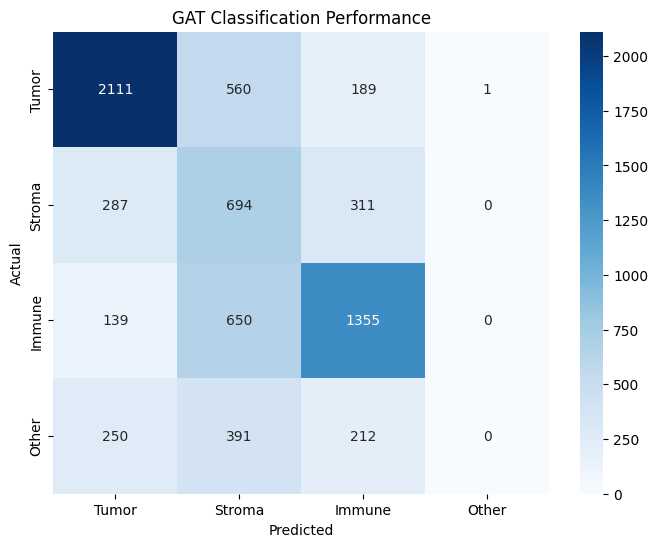

In [17]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch)
        y_true.extend(batch.y.cpu().numpy())
        y_pred.extend(out.argmax(dim=1).cpu().numpy())

# Generate Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('GAT Classification Performance')
plt.show()

# GAT_V2

In [18]:
class NuCLSDataset(Dataset):
    def __init__(self, root, split_file, csv_dir, mode='train'):
        self.csv_dir = csv_dir
        self.file_list = pd.read_csv(split_file)
        self.slides = self.file_list['slide_name'].unique().tolist()
        self.local_processed_dir = f"/content/processed_{mode}_v2"  # New folder for v2 data

        if not os.path.exists(self.local_processed_dir):
            os.makedirs(self.local_processed_dir)

        super(NuCLSDataset, self).__init__(root)

    @property
    def processed_file_names(self):
        files = [f for f in os.listdir(self.local_processed_dir) if f.endswith('.pt')]
        return files

    def process(self):
        all_csvs = [f for f in os.listdir(self.csv_dir) if f.endswith('.csv')]
        count = 0
        print(f"Processing {len(self.slides)} slides with Shape Features...")

        for slide in self.slides:
            matching_fovs = [f for f in all_csvs if f.startswith(slide)]
            for fov in matching_fovs:
                df = pd.read_csv(os.path.join(self.csv_dir, fov))
                if len(df) < 2: continue

                # --- NEW FEATURE ENGINEERING ---
                # 1. Coordinates
                pos_np = np.stack([(df['xmin']+df['xmax'])/2, (df['ymin']+df['ymax'])/2], axis=1)
                pos = torch.from_numpy(pos_np).to(torch.float)

                # 2. Geometry
                width = df['xmax'] - df['xmin']
                height = df['ymax'] - df['ymin']

                # Feature A: Log-Normalized Area
                # np.log1p is safer than np.log as it handles zero values gracefully
                area_raw = (width * height).values
                area = np.log1p(area_raw)
                area = torch.from_numpy(area).to(torch.float).view(-1, 1)

                # Feature B: Aspect Ratio (Critical for Fibroblasts)
                # Long skinny cells will have high ratio, round cells ~1.0
                aspect = (width / (height + 1e-6)).values
                aspect = torch.from_numpy(aspect).to(torch.float).view(-1, 1)

                # Feature Vector x: [Area, AspectRatio, X, Y] (4 dims)
                x = torch.cat([area, aspect, pos/1000.0], dim=1)

                # 3. Labels & Graph
                y = torch.tensor(df.apply(get_class_id, axis=1).values, dtype=torch.long)

                k = min(6, len(df))
                nbrs = NearestNeighbors(n_neighbors=k).fit(pos_np)
                adj = nbrs.kneighbors_graph(pos_np).tocoo()
                edge_index = torch.from_numpy(np.array([adj.row, adj.col])).to(torch.long)

                data = Data(x=x, edge_index=edge_index, y=y, pos=pos)
                torch.save(data, os.path.join(self.local_processed_dir, f'data_{count}.pt'))
                count += 1

        print(f"Created {count} morphology-aware graphs.")

    def len(self): return len([f for f in os.listdir(self.local_processed_dir) if f.endswith('.pt')])
    def get(self, idx): return torch.load(os.path.join(self.local_processed_dir, f'data_{idx}.pt'), weights_only=False)

In [19]:
class PathologyGAT_V2(torch.nn.Module):
    def __init__(self, in_channels=4, hidden_channels=64, out_channels=4):
        super(PathologyGAT_V2, self).__init__()

        # Layer 1: Captures local morphology
        self.conv1 = GATConv(in_channels, hidden_channels, heads=8, concat=True)
        self.bn1 = BatchNorm(hidden_channels * 8)

        # Layer 2: Captures spatial context
        # We add 'edge_dim=1' if you decide to pass distance, but for now we'll stick to heads
        self.conv2 = GATConv(hidden_channels * 8, hidden_channels, heads=8, concat=True)
        self.bn2 = BatchNorm(hidden_channels * 8)

        # Layer 3: The "Decision" layer
        self.conv3 = GATConv(hidden_channels * 8, hidden_channels, heads=1, concat=False)

        # Final Linear Layer
        self.lin = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, data, return_att=False):
        x, edge_index = data.x, data.edge_index

        # 1. Feature Normalization
        x = (x - x.mean(dim=0, keepdim=True)) / (x.std(dim=0, keepdim=True) + 1e-6)

        # 2. Block 1
        x1 = self.conv1(x, edge_index)
        x1 = self.bn1(x1)
        x1 = F.elu(x1)
        x1 = F.dropout(x1, p=0.3, training=self.training)

        # 3. Block 2
        x2 = self.conv2(x1, edge_index)
        x2 = self.bn2(x2)
        x2 = F.elu(x2)
        # Residual Connection: Adds the previous layer's info to the current one
        # This prevents 'vanishing gradients' in deep graphs
        x = x2 + x1

        # 4. Final Attention Layer (Interpretability)
        if return_att:
            x, (att_edge, att_val) = self.conv3(x, edge_index, return_attention_weights=True)
            return F.log_softmax(self.lin(x), dim=1), att_edge, att_val
        else:
            x = self.conv3(x, edge_index)
            return F.log_softmax(self.lin(x), dim=1)

In [20]:
# ==========================================
# EXECUTION & TRAINING LOOP
# ==========================================

# A. Initialize Datasets with MODE (Train vs Test)
train_split = os.path.join(SPLITS_DIR, "fold_1_train.csv")
test_split = os.path.join(SPLITS_DIR, "fold_1_test.csv")

print("--- initializing TRAIN dataset ---")
train_dataset = NuCLSDataset(root='/content/', split_file=train_split, csv_dir=CSV_DIR, mode='train')
print("--- initializing TEST dataset ---")
test_dataset = NuCLSDataset(root='/content/', split_file=test_split, csv_dir=CSV_DIR, mode='test')

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# B. Model Setup
model_gat_2 = PathologyGAT_V2().to(device)
optimizer = torch.optim.Adam(model_gat_2.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)
class_weights = calculate_global_weights(train_dataset).to(device)

print(f"\n Starting 100 Epoch Training...")

# C. Training Loop
for epoch in range(1, 101):
    model_gat_2.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model_gat_2(batch)
        loss = F.nll_loss(out, batch.y, weight=class_weights)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # D. Validation Phase (Every 5 epochs)
    if epoch % 5 == 0 or epoch == 1:
        model_gat_2.eval()
        val_preds, val_labels = [], []

        with torch.no_grad():
            for batch in test_loader:
                batch = batch.to(device)
                out = model_gat_2(batch)
                val_preds.append(out.argmax(dim=1).cpu().numpy())
                val_labels.append(batch.y.cpu().numpy())

        y_true = np.concatenate(val_labels)
        y_pred = np.concatenate(val_preds)
        val_acc = accuracy_score(y_true, y_pred)
        val_f1 = f1_score(y_true, y_pred, average='macro')

        print(f"Epoch {epoch:03d} | Loss: {total_loss/len(train_loader):.4f} | Val Acc: {val_acc:.3f} | Val F1: {val_f1:.3f}")

torch.save(model_gat_2.state_dict(), 'pathology_gat_v2_final.pth')
print(" Done!")

--- initializing TRAIN dataset ---


Processing...


Processing 102 slides with Shape Features...
Created 1481 morphology-aware graphs.
--- initializing TEST dataset ---
Processing 22 slides with Shape Features...


Done!
Processing...


Created 263 morphology-aware graphs.
Calculating biologically-balanced class weights...


Done!



 Starting 100 Epoch Training...
Epoch 001 | Loss: 1.2212 | Val Acc: 0.547 | Val F1: 0.410
Epoch 005 | Loss: 1.1034 | Val Acc: 0.572 | Val F1: 0.434
Epoch 010 | Loss: 1.0935 | Val Acc: 0.590 | Val F1: 0.452
Epoch 015 | Loss: 1.0868 | Val Acc: 0.596 | Val F1: 0.447
Epoch 020 | Loss: 1.0795 | Val Acc: 0.598 | Val F1: 0.457
Epoch 025 | Loss: 1.0811 | Val Acc: 0.580 | Val F1: 0.459
Epoch 030 | Loss: 1.0595 | Val Acc: 0.601 | Val F1: 0.467
Epoch 035 | Loss: 1.0710 | Val Acc: 0.561 | Val F1: 0.437
Epoch 040 | Loss: 1.0711 | Val Acc: 0.584 | Val F1: 0.461
Epoch 045 | Loss: 1.0545 | Val Acc: 0.598 | Val F1: 0.458
Epoch 050 | Loss: 1.0559 | Val Acc: 0.572 | Val F1: 0.447
Epoch 055 | Loss: 1.0571 | Val Acc: 0.576 | Val F1: 0.453
Epoch 060 | Loss: 1.0525 | Val Acc: 0.566 | Val F1: 0.453
Epoch 065 | Loss: 1.0679 | Val Acc: 0.587 | Val F1: 0.460
Epoch 070 | Loss: 1.0523 | Val Acc: 0.572 | Val F1: 0.449
Epoch 075 | Loss: 1.0522 | Val Acc: 0.579 | Val F1: 0.471
Epoch 080 | Loss: 1.0611 | Val Acc: 0.5

In [21]:
# 1. Ensure model is in evaluation mode
model_gat_2.eval()
all_y_true = []
all_y_pred = []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model_gat_2(batch)
        all_y_true.extend(batch.y.cpu().numpy())
        all_y_pred.extend(out.argmax(dim=1).cpu().numpy())

# 2. Calculate Overall Accuracy
overall_acc = accuracy_score(all_y_true, all_y_pred)

print(f"=======================================")
print(f" OVERALL TEST ACCURACY GAT_V2: {overall_acc*100:.2f}%")
print(f"=======================================\n")

# 3. Calculate Per-Class Accuracy (The "Deep Dive")
cm = confusion_matrix(all_y_true, all_y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)

for i, class_name in enumerate(CLASSES):
    print(f" {class_name} Accuracy: {per_class_acc[i]*100:.2f}%")

 OVERALL TEST ACCURACY GAT_V2: 57.73%

 Tumor Accuracy: 68.26%
 Stroma Accuracy: 57.35%
 Immune Accuracy: 66.32%
 Other Accuracy: 1.41%


In [31]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_attention(model, dataset, idx=0):
    """
    Draws the cell graph. Thick lines = Strong Attention.
    """
    model.eval()
    data = dataset[idx].to(device)

    # 1. Get the model's "Brain Waves" (Attention Weights)
    # We need to run forward pass and request attention
    with torch.no_grad():
        # Note: We need to modify forward() slightly to get weights if using standard GATConv
        # But for now, let's visualize the *Predictions* vs *Ground Truth* spatially
        out = model(data)
        pred = out.argmax(dim=1).cpu().numpy()
        true = data.y.cpu().numpy()

    pos = data.pos.cpu().numpy()

    # 2. Setup Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    fig.suptitle(f"Attention Visualization for GAT V2 (Slide {idx})", fontsize=20)

    # Color Map: 0=Tumor(Red), 1=Fibro(Green), 2=Lymph(Blue), 3=Other(Grey)
    colors = ['#FF4444', '#44FF44', '#4444FF', '#AAAAAA']

    # 3. Plot Ground Truth
    ax1.set_title(f"Ground Truth (Slide {idx})", fontsize=15)
    for class_id in range(4):
        mask = true == class_id
        if mask.any():
            ax1.scatter(pos[mask, 0], pos[mask, 1], c=colors[class_id],
                       label=CLASSES[class_id], s=100, edgecolors='black')
    ax1.legend()
    ax1.invert_yaxis() # Histology images have (0,0) at top-left

    # 4. Plot GAT Prediction
    ax2.set_title(f"GAT Prediction (Acc: {accuracy_score(true, pred):.2f})", fontsize=15)
    for class_id in range(4):
        mask = pred == class_id
        if mask.any():
            ax2.scatter(pos[mask, 0], pos[mask, 1], c=colors[class_id],
                       label=CLASSES[class_id], s=100, edgecolors='black')
    ax2.invert_yaxis()

    # Draw connections (KNN Graph)
    edge_index = data.edge_index.cpu().numpy()
    for i in range(edge_index.shape[1]):
        start = pos[edge_index[0, i]]
        end = pos[edge_index[1, i]]
        # Draw faint lines to show the "Graph" structure
        ax2.plot([start[0], end[0]], [start[1], end[1]], c='black', alpha=0.1)

    plt.show()




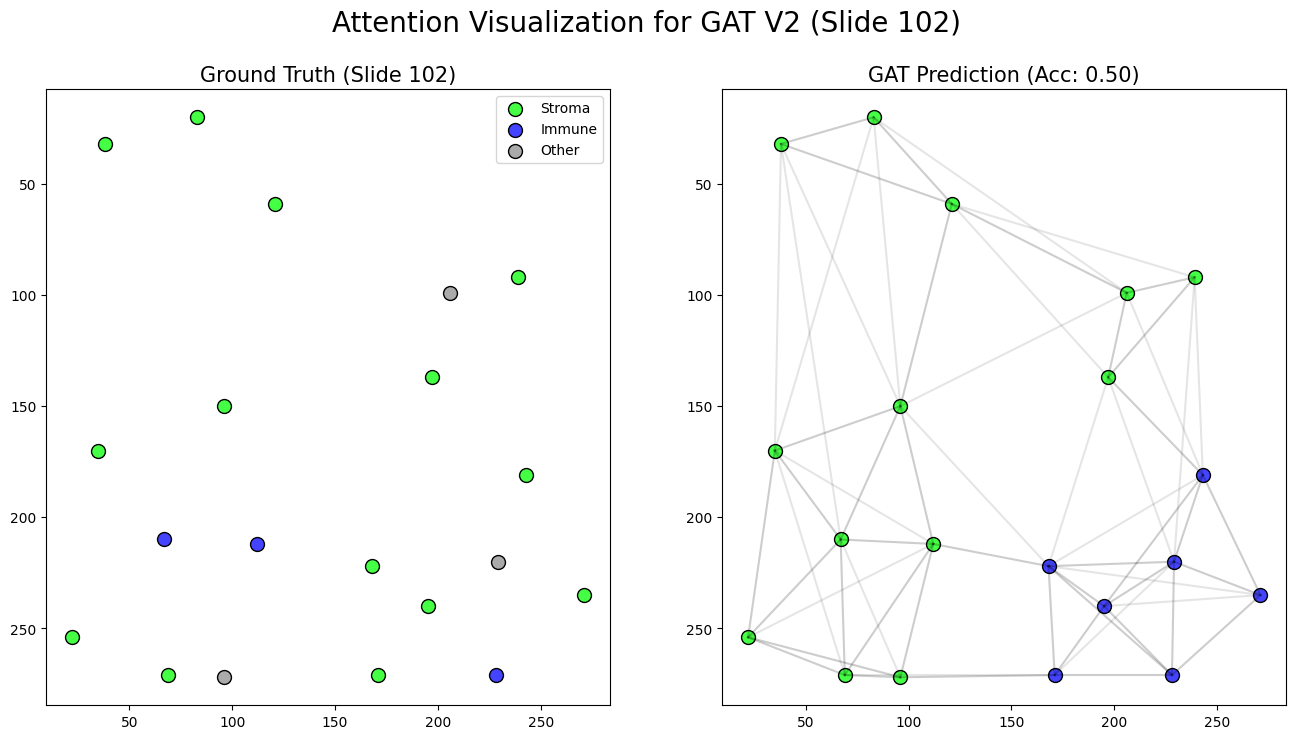

In [37]:
# print("Visualizing Graph #102 ")
visualize_attention(model_gat_2, test_dataset, idx=102)